In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tableone as tb

warnings.simplefilter(action='ignore')

from src.pathology.core import determine_amyloid_status, compute_roi_tau, compute_roi_amyloid, compute_roi_ct
from src.pathology.cutoffs import is_above_cutoff, find_combined_cutoff
from src.pathology.laterality import laterality_index, calculate_regional_laterality

from src.connectomics.atlases import get_dk_rois

from src.analysis.stats import ols_comparison
from src.analysis.misc import set_plot_style, add_significance
from src.analysis.surf import shorten_dk_names, plot_surface

# in
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))

df_dir = os.path.join(data_dir, 'bf2_20240927')
mri_fc_dir = os.path.join(data_dir, 'fc')
mri_sc_dir = os.path.join(data_dir, 'act')

df_fname = os.path.join(df_dir, 'toomas__20240927_090835.csv')
taupetqc_fname = os.path.join(df_dir, 'v2_tauPET_QC_for_database_June2023.xlsx')

export_dir = os.path.join(data_dir, 'datasets')
os.makedirs(export_dir, exist_ok=True)

# out
media_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'media'))

plot_dir = os.path.join(media_dir, '_plots')
surfplot_dir = os.path.join(plot_dir, 'surfs')
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(surfplot_dir, exist_ok=True)

In [2]:
tau_prefix = 'tnic'
amy_prefix = 'fnc'

df_ = pd.read_csv(df_fname, low_memory=False)
print(f"N (raw) = {df_.shape}")

### cut-off

# if non partial volume corrected, use pre-defined cutoffs
if tau_prefix == 'tnic':
    cutoffs = {'cho_com_I_IV': 1.362}
# else if partial volume corrected, estimate cut-offs
elif tau_prefix == 'tgic':
    # sample selection
    df_gmm = df_.copy()
    df_gmm = df_gmm[df_gmm['excluded']!=1]
    df_gmm = df_gmm[df_gmm['diagnosis_baseline_variable'].isin(['AD', 'SCD', 'MCI', 'Normal'])]
    df_gmm = df_gmm.loc[df_gmm['age']>50]
    df_gmm['amyloid_positive'] = df_gmm.apply(determine_amyloid_status, axis=1)
    df_gmm = df_gmm.loc[df_gmm.groupby('mid')['Visit'].idxmin()]
    df_gmm = df_gmm.dropna(subset=['amyloid_positive', 'diagnosis_baseline_variable', f'{tau_prefix}_cho_com_I_IV'])
    print(f"Data shape (cut-off estimation): {df_gmm.shape}")

    cutoffs = {}
    for region in ['cho_com_I_IV']:
        tau_col = f'{tau_prefix}_{region}'

        # estimate the combined cut-offs (average of GMM of CU+CI & 2SD A-CU)
        scores_gmm = df_gmm[tau_col].to_numpy()
        scores_2std = df_gmm.loc[(df_gmm['diagnosis_baseline_variable']=='Normal') & (df_gmm['amyloid_positive']==0), tau_col].to_numpy()

        cutoffs[region] = find_combined_cutoff(scores_gmm=scores_gmm, scores_2std=scores_2std, roi_name=tau_col, verbose=False)

### get all PET columns

# tau-PET
taupet_cols = [
    col for col in df_.columns 
    if (col.startswith(f'{tau_prefix}_sr_mr_fs_ctx_') and 'unknown' not in col) or 
       (col.startswith(f'{tau_prefix}_sr_mr_fs_') and ('Hippocampus' in col or 'Amygdala' in col))
]

# amyloid-PET
amypet_cols = [
    col for col in df_.columns 
    if (col.startswith(f'{amy_prefix}_sr_mr_fs_ctx_') and 'unknown' not in col) or 
       (col.startswith(f'{amy_prefix}_sr_mr_fs_') and ('Hippocampus' in col or 'Amygdala' in col))
]

### defining ROIs

ROIs = get_dk_rois()

### study cohort selection

df = df_[df_['excluded']!=1].copy()
df = df[(df['study_cohort_baseline_variable'] != 'BF2_E') & (df['study_cohort_baseline_variable'].notna())]
df = df[df['diagnosis_baseline_variable'].isin(['AD', 'SCD', 'MCI', 'Normal'])]
df = df[~df['underlying_etiology_text_baseline_variable'].isin(['Brain Tumor', 'NPH', 'PSP', 'nfvPPA', 'bvFTD', 'CBS', 'MSA', np.nan])]
df = df.dropna(subset=taupet_cols)
df = df.loc[df['age']>50]
print(f"N (cohort selection) = {df.shape}")

### pathology

# amyloid status and forward fill from previous timepoints
df['amyloid_positive'] = df.apply(determine_amyloid_status, axis=1)
df = df.sort_values(by=['sid', 'Visit'])
df['amyloid_positive'] = df.groupby('sid')['amyloid_positive'].transform(lambda x: x.ffill())

# tau positivity status cho I-IV (temporal meta-ROI) and load in the most-affected hemisphere
df['tau_positive'] = is_above_cutoff(df[f'{tau_prefix}_cho_com_I_IV_L'], cutoffs['cho_com_I_IV']) | \
    is_above_cutoff(df[f'{tau_prefix}_cho_com_I_IV_R'], cutoffs['cho_com_I_IV'])

# PET averages in all defined ROIs for both hemispheres
for ROI_name, ROI_regions in ROIs.items():
    # amyloid-PET
    df[f'{amy_prefix}_{ROI_name}_left'] = compute_roi_amyloid(df, ROI_regions, ['_lh_', '_Left'], pet_prefix=f'{amy_prefix}_sr_mr_fs_', vol_prefix=f'{amy_prefix}_vx_fs_')
    df[f'{amy_prefix}_{ROI_name}_right'] = compute_roi_amyloid(df, ROI_regions, ['_rh_', '_Right'], pet_prefix=f'{amy_prefix}_sr_mr_fs_', vol_prefix=f'{amy_prefix}_vx_fs_')
    df[f'{amy_prefix}_{ROI_name}'] = compute_roi_amyloid(df, ROI_regions, ['_lh_', '_Left', '_rh_', '_Right'], pet_prefix=f'{amy_prefix}_sr_mr_fs_', vol_prefix=f'{amy_prefix}_vx_fs_')
    # amyloid laterality index
    df[f'{amy_prefix}_{ROI_name}_LI'] = df.apply(lambda row: laterality_index(
        row[f'{amy_prefix}_{ROI_name}_left'], row[f'{amy_prefix}_{ROI_name}_right']), axis=1)
    # most affected hemisphere amyloid
    df[f'{amy_prefix}_{ROI_name}_most_hemi'] = df[[f'{amy_prefix}_{ROI_name}_left', f'{amy_prefix}_{ROI_name}_right']].max(axis=1)
    
    # tau-PET
    df[f'{tau_prefix}_{ROI_name}_left'] = compute_roi_tau(df, ROI_regions, ['_lh_', '_Left'], pet_prefix=f'{tau_prefix}_sr_mr_fs_', vol_prefix=f'{tau_prefix}_vx_fs_')
    df[f'{tau_prefix}_{ROI_name}_right'] = compute_roi_tau(df, ROI_regions, ['_rh_', '_Right'], pet_prefix=f'{tau_prefix}_sr_mr_fs_', vol_prefix=f'{tau_prefix}_vx_fs_')
    df[f'{tau_prefix}_{ROI_name}'] = compute_roi_tau(df, ROI_regions, ['_lh_', '_Left', '_rh_', '_Right'], pet_prefix=f'{tau_prefix}_sr_mr_fs_', vol_prefix=f'{tau_prefix}_vx_fs_')
    # tau laterality index
    df[f'{tau_prefix}_{ROI_name}_LI'] = df.apply(lambda row: laterality_index(
        row[f'{tau_prefix}_{ROI_name}_left'], row[f'{tau_prefix}_{ROI_name}_right']), axis=1)
    # most affected hemisphere tau
    df[f'{tau_prefix}_{ROI_name}_most_hemi'] = df[[f'{tau_prefix}_{ROI_name}_left', f'{tau_prefix}_{ROI_name}_right']].max(axis=1)
    
    # CT
    df[f'aparc_ct_{ROI_name}_left'] = compute_roi_ct(df, ROI_regions, ['_L'], prefix='aparc_ct_avg')
    df[f'aparc_ct_{ROI_name}_right'] = compute_roi_ct(df, ROI_regions, ['_R'], prefix='aparc_ct_avg')
    df[f'aparc_ct_{ROI_name}_LI'] = df.apply(lambda row: laterality_index(
        row[f'aparc_ct_{ROI_name}_left'], row[f'aparc_ct_{ROI_name}_right']), axis=1)

# calculate ROI-based tau asymmetry indeces 
df = calculate_regional_laterality(df, amypet_cols, prefix=f"{amy_prefix}_", suffix="_LI")
df = calculate_regional_laterality(df, taupet_cols, prefix=f"{tau_prefix}_", suffix="_LI")
print(f"N (ROI-based laterality) = {df.shape}")

print(f"N (pathology) = {df.shape}")

### tau-PET QC

df_qc = pd.read_excel(taupetqc_fname).sort_values(by='sid', ascending=True).reset_index(drop=True)
df = df.merge(df_qc[['mid', 'Exclude_tauPET', 'Comments_tauPET_pattern']], left_on='tau_pet_date__index', right_on='mid', how='left')
df = df[(df['Exclude_tauPET'] == 0) | (pd.isna(df['Exclude_tauPET']))].drop(columns=['mid_y', 'Exclude_tauPET'])
df = df.rename(columns={'mid_x': 'mid'})
df['raw_img_date_Tau_PET'] = pd.to_datetime(df['raw_img_date_Tau_PET'].astype(int).astype(str))
print(f"N (tau-PET QC) = {df.shape}")

### first amyloid positive timepoint

# amyloid positive
df = df.loc[(df['amyloid_positive']==1)]
print(f"N (amyloid positive) = {df.shape}")

# make copy for longitudinal sample
df_ld = df.copy()
print(f"N1 (separate longitudinal sample) = {df_ld.shape}")

# first possible timepoint to create cross-sectional sample
df = df.loc[df.groupby('mid')['Visit'].idxmin()]
print(f"N2 (first timepoint ie cross-sectional sample) = {df.shape}")

N (raw) = (16034, 2896)
N (cohort selection) = (2842, 2896)
N (ROI-based laterality) = (2842, 3184)
N (pathology) = (2842, 3184)
N (tau-PET QC) = (2780, 3185)
N (amyloid positive) = (1390, 3185)
N1 (separate longitudinal sample) = (1390, 3185)
N2 (first timepoint ie cross-sectional sample) = (837, 3185)


LI thresholds = [-9.7, -8.78, 8.78, 9.7]
N (A+T+) = (475, 3187)
N (A+T-) = (362, 3187)

Average temporal tau load, SUVR
tvals:
{('S', 'LA'): -1.577, ('S', 'RA'): -2.688, ('LA', 'RA'): -1.746}
pvals:
{('S', 'LA'): 0.347, ('S', 'RA'): 0.023, ('LA', 'RA'): 0.249}

Most affected hemisphere temporal tau load, SUVR
tvals:
{('S', 'LA'): -4.828, ('S', 'RA'): -5.24, ('LA', 'RA'): -1.839}
pvals:
{('S', 'LA'): 0.0, ('S', 'RA'): 0.0, ('LA', 'RA'): 0.204}

Average global tau load, SUVR
tvals:
{('S', 'LA'): 0.074, ('S', 'RA'): -1.315, ('LA', 'RA'): -1.636}
pvals:
{('S', 'LA'): 1.0, ('S', 'RA'): 0.568, ('LA', 'RA'): 0.312}


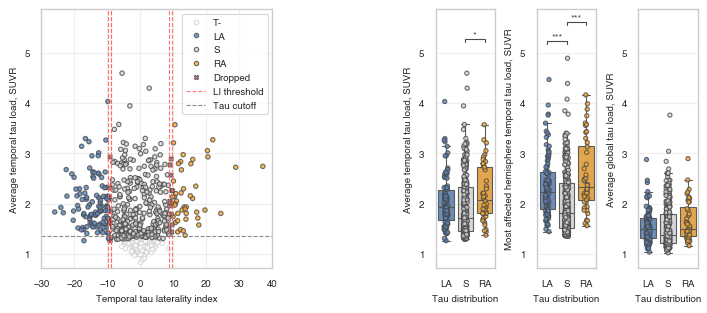

all = 475
dropped = 23 (4.8%)
N (final sample) = 452
N (LA) = 102 (22.6%)
N (S) = 306 (67.7%)
N (RA) = 44 (9.7%)


In [3]:
def modify_handles(input_list, index_to_remove=None, index_to_move=None, target_index=None):
    # remove the specified handle by index
    if index_to_remove is not None and 0 <= index_to_remove < len(input_list):
        input_list.pop(index_to_remove)
        # adjust indices if necessary due to the removal
        if index_to_move is not None and index_to_remove < index_to_move:
            index_to_move -= 1
        if target_index is not None and index_to_remove < target_index:
            target_index -= 1
    # move the specified handle to the new position
    if index_to_move is not None and target_index is not None:
        if 0 <= index_to_move < len(input_list) and 0 <= target_index < len(input_list):
            input_list.insert(target_index + 1, input_list.pop(index_to_move))
    return input_list

df_g = df.copy()

li_col = f'{tau_prefix}_temporal_meta_LI'
tnic_col = f'{tau_prefix}_temporal_meta'
grp_col = 'temporal_meta_tau_asymmetry_group'
grp2_col = 'temporal_meta_tau_asymmetry_group_v2' # not using in paper

### grouping

# calculate laterality index mean and std
li_std = np.std(df_g.loc[df_g['tau_positive']==True, li_col])

# set main asymmetry group
drop_int = li_std*0.05
li_thr = [0-1*li_std-drop_int, 0-1*li_std+drop_int, 0+1*li_std-drop_int, 0+1*li_std+drop_int]
df_g[grp_col] = pd.cut(df_g[li_col], labels=['LA', 'LA-S', 'S', 'RA-S', 'RA'],
                       bins=[-np.inf, li_thr[0], li_thr[1], li_thr[2], li_thr[3], np.inf])
print(f"LI thresholds = {[round(value, 2) for value in li_thr]}")

# set sensitivity asymmetry group
li_thr2 = [0-1*li_std, 0+1*li_std]
df_g[grp2_col] = pd.cut(df_g[li_col], labels=['LA', 'S', 'RA'],
                        bins=[-np.inf, li_thr2[0], li_thr2[1], np.inf])

# T+ and T- separation
df_g_t = df_g.loc[df_g['tau_positive']==True, :]
df_g_tneg = df_g.loc[df_g['tau_positive']==False, :]
print(f"N (A+T+) = {df_g_t.shape}")
print(f"N (A+T-) = {df_g_tneg.shape}")

### plotting

set_plot_style(dpi=100)

fig, axs = plt.subplots(1, 5, figsize=(180/25.4, 80/25.4), gridspec_kw={'width_ratios': [3.5, 1.2, 0.9, 0.9, 0.9]})

scatter_kwargs = dict(s=10, lw=0.8, alpha=0.8)
line_kwargs = dict(alpha=0.9, lw=0.8, linestyle='--')
box_kwargs = dict(alpha=0.95, lw=0.8)
strip_kwargs = dict(linewidth=0.8, size=3, alpha=0.8, edgecolor='#494949')
pval_kwargs = dict(lw=0.8, fontsize=7, col='#494949', h_coef=0.015, y_coef=0.1)

grp_order = ['LA', 'S', 'RA']
grp_markers = {'LA': 'o', 'LA-S': 'X', 'S': 'o', 'RA-S': 'X', 'RA': 'o'}
grp_colors = {'LA': '#5785C1FF', 'LA-S': '#ff6961', 'S': '#D3D4D8FF', 'RA-S': '#ff6961', 'RA': '#FBA72AFF'} # AsteroidCity3
grp_comparisons = [('S', 'LA'), ('S', 'RA'), ('LA', 'RA')]
covars = ['age', 'gender_baseline_variable']

vminmax = [df_g[f'{tnic_col}_most_hemi'].min()*0.85, df_g[f'{tnic_col}_most_hemi'].max()*1.2]

for i, ax in enumerate(axs):
    # plot grouping scatterplot
    if i == 0:
        sns.scatterplot(ax=ax, data=df_g_tneg, x=li_col, y=tnic_col, **scatter_kwargs,
                        markers={'Tau negative': 's'}, color='white', label='T-', edgecolor='lightgray')
        sns.scatterplot(ax=ax, data=df_g_t, x=li_col, y=tnic_col, **scatter_kwargs,
                        hue=grp_col, style=grp_col, edgecolor='#494949', markers=grp_markers, palette=grp_colors)

        ax.axvline(x=li_thr[0], color='#ff6961', **line_kwargs)
        ax.axvline(x=li_thr[1], color='#ff6961', **line_kwargs)
        ax.axvline(x=li_thr[1], color='#ff6961', **line_kwargs)
        ax.axvline(x=li_thr[2], color='#ff6961', **line_kwargs)
        ax.axvline(x=li_thr[3], color='#ff6961', label='LI threshold', **line_kwargs)
        ax.axhline(y=cutoffs['cho_com_I_IV'], color='gray', label='Tau cutoff', **line_kwargs)

        handles, labels = ax.get_legend_handles_labels()
        modified_handles = modify_handles(handles, index_to_remove=2, index_to_move=4, target_index=4)
        ax.legend(handles=modified_handles, labels=['T-', 'LA', 'S', 'RA', 'Dropped', 'LI threshold', 'Tau cutoff'])
        ax.set_xlabel('Temporal tau laterality index')
        ax.set_ylabel('Average temporal tau load, SUVR')
        ax.set_ylim(vminmax)
        ax.set_xlim([-30, 40])
    # empty axis for later surface plots
    elif i==1:
        ax.axis('off')
    # plot tau load comparison boxplots
    else:
        if i == 2:
            y = tnic_col
            ylabel = 'Average temporal tau load, SUVR'
        elif i == 3:
            y = f'{tnic_col}_most_hemi'
            ylabel = 'Most affected hemisphere temporal tau load, SUVR'
        elif i == 4:
            y = f'{tau_prefix}_cho_com_I_VI'
            ylabel = 'Average global tau load, SUVR'
        
        data = {
            'LA': df_g_t.loc[df_g_t[grp_col]=='LA', y].to_numpy(),
            'S': df_g_t.loc[df_g_t[grp_col]=='S', y].to_numpy(),
            'RA': df_g_t.loc[df_g_t[grp_col]=='RA', y].to_numpy()
        }
        dfs_covars = {
            'LA': df_g_t.loc[df_g_t[grp_col]=='LA', covars],
            'S': df_g_t.loc[df_g_t[grp_col]=='S', covars],
            'RA': df_g_t.loc[df_g_t[grp_col]=='RA', covars]
        }

        data_args = dict(ax=ax, y=y, x=grp_col, data=df_g_t, order=grp_order, palette=grp_colors)
        sns.boxplot(**data_args, showfliers=False)
        sns.stripplot(**data_args, **strip_kwargs)
        ax.set_xlabel('Tau distribution')
        ax.set_ylabel(ylabel)

        for box in ax.patches:
            box.set_linewidth(box_kwargs['lw'])
            box.set_alpha(box_kwargs['alpha'])
        for line in ax.lines:
            line.set_linewidth(box_kwargs['lw'])
            line.set_alpha(box_kwargs['alpha'])

        tvals, pvals, pvals_cor, models = ols_comparison(dfs_covars, data, grp_comparisons, covars=covars, posthoc='bonferroni')
        _tvals = {grps: round(tval, 3) for grps, tval in tvals.items()}
        _pvals_cor = {grps: round(pval, 3) for grps, pval in pvals_cor.items()}
        print(f'\n{ylabel}')
        print(f'tvals:\n{_tvals}')
        print(f'pvals:\n{_pvals_cor}')

        if grp_comparisons is not None and pvals_cor is not None:
            add_significance(ax, grp_order, grp_comparisons, pvals_cor, hide_ns=True, **pval_kwargs)
        ax.set_ylim(vminmax)

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f'groups_scatterboxplots_{tau_prefix}_{amy_prefix}.pdf'), format='pdf', dpi=300)
plt.show()

n_drop = len(df_g_t[df_g_t[grp_col].isin(['LA-S', 'RA-S'])])
n_total = len(df_g_t[df_g_t[grp_col].isin(['LA', 'S', 'RA'])])
n_LA = len(df_g_t[df_g_t[grp_col]=='LA'])
n_S = len(df_g_t[df_g_t[grp_col]=='S'])
n_RA = len(df_g_t[df_g_t[grp_col]=='RA'])

print(f"all = {len(df_g_t)}")
print(f"dropped = {n_drop} ({n_drop/len(df_g_t)*100:.1f}%)")
print(f'N (final sample) = {n_total}')
print(f'N (LA) = {n_LA} ({n_LA/n_total*100:.1f}%)')
print(f'N (S) = {n_S} ({n_S/n_total*100:.1f}%)')
print(f'N (RA) = {n_RA} ({n_RA/n_total*100:.1f}%)')

df_g_t = df_g_t[df_g_t[grp_col].isin(['LA', 'S', 'RA'])]

# export grouped xs and long datasets
df_g_t.to_csv(os.path.join(export_dir, f'bf2_tau_asymmetry_ad_t_xs_{tau_prefix}_{amy_prefix}.csv'))
# df_ld_g = pd.merge(df_ld, df_g[['mid', grp_col]], on='mid', how='left')
df_ld.to_csv(os.path.join(export_dir, f'bf2_tau_asymmetry_ad_long_{tau_prefix}_{amy_prefix}.csv'))

In [4]:
### FC

# read in dirs of all subjects
fc_subjects = next(os.walk(mri_fc_dir))[1]

# df setup for FC
df_fc = pd.DataFrame(data={'subject_fc_id': fc_subjects})
df_fc['mid'] = df_fc['subject_fc_id'].str.replace('_subject_id_', '', 1).str.split('__').str[0]
df_fc['fc_dir'] = df_fc['subject_fc_id'].apply(lambda x: os.path.join(mri_fc_dir, x))
df_fc['fc_mid_date'] = df_fc['subject_fc_id'].str.replace('_subject_id_', '', 1)
print(f"N (all FC) = {df_fc.shape}")

# merge FC dirs to main df & create file cols
df_g_t_fc = df_g_t.merge(df_fc, on='mid', how='left')
df_g_t_fc = df_g_t.merge(df_fc[['fc_mid_date', 'fc_dir']], left_on='mri_date__index', 
                          right_on='fc_mid_date', how='left')
df_g_t_fc['dk_fc_file'] = df_g_t_fc['fc_dir'].apply(
    lambda x: os.path.join(x, 'fc_aparcaseg.csv') if pd.notna(x) else np.nan)
print(f"N (FC merged to main; with NaNs) = {df_g_t_fc.shape}")
print(f"N (FC merged to main; without NaNs) = {df_g_t_fc.dropna(subset='fc_mid_date').shape}")

### SC

# read in dirs of all subjects+scans
sc_subjects = next(os.walk(mri_sc_dir))[1]
sc_subjects_scans = []
for sub in sc_subjects:
    scans = next(os.walk(os.path.join(mri_sc_dir, sub)))[1]
    for scan in scans:
        sc_subjects_scans.append([sub, scan])

# df setup for SC
df_sc = pd.DataFrame(data={'subject_scan_id': sc_subjects_scans})
df_sc['mid'] = df_sc['subject_scan_id'].apply(lambda x: x[0])
df_sc['date'] = df_sc['subject_scan_id'].apply(lambda x: x[1])
df_sc['sc_dir'] = df_sc.apply(lambda row: os.path.join(mri_sc_dir, row['mid'], row['date']), axis=1)
df_sc['sc_mid_date'] = (df_sc['mid'] + '__' + df_sc['date']).str[:-2]
print(f"N (all SC) = {df_sc.shape}")

# merge SC dirs to main df & create file cols
df_g_t_cc = df_g_t_fc.merge(df_sc[['sc_mid_date', 'sc_dir']], left_on='mri_date__index', 
                          right_on='sc_mid_date', how='left')
df_g_t_cc['dk_sc_file'] = df_g_t_cc['sc_dir'].apply(
    lambda x: os.path.join(x, 'sc_sift2_10000000.csv') if pd.notna(x) else np.nan)
df_g_t_cc['dk_fa_file'] = df_g_t_cc['sc_dir'].apply(
    lambda x: os.path.join(x, 'sc_fa_10000000.csv') if pd.notna(x) else np.nan)
df_g_t_cc['dk_md_file'] = df_g_t_cc['sc_dir'].apply(
    lambda x: os.path.join(x, 'sc_adc_10000000.csv') if pd.notna(x) else np.nan)
print(f"N (SC merged to main; with NaNs) = {df_g_t_cc.shape}")
print(f"N (SC merged to main; without NaNs) = {df_g_t_cc.dropna(subset='sc_mid_date').shape}")

### export
df_g_t_cc.to_csv(os.path.join(export_dir, f'bf2_tau_asymmetry_ad_t_xs_{tau_prefix}_{amy_prefix}_mri.csv'))

N (all FC) = (1327, 4)
N (FC merged to main; with NaNs) = (452, 3190)
N (FC merged to main; without NaNs) = (318, 3190)
N (all SC) = (1058, 5)
N (SC merged to main; with NaNs) = (452, 3195)
N (SC merged to main; without NaNs) = (352, 3195)


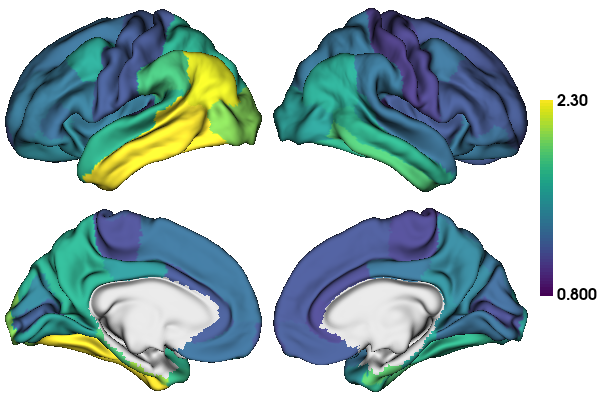

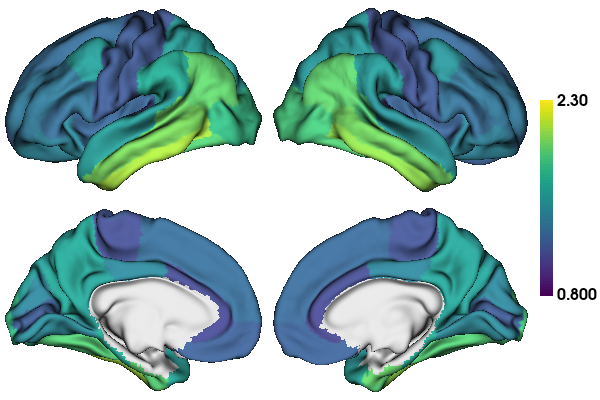

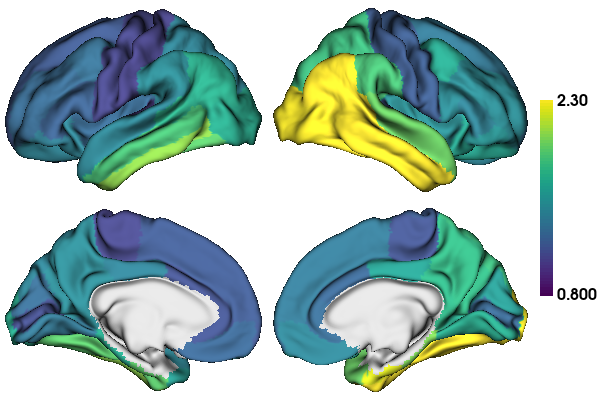

In [5]:
if tau_prefix == "tnic": cmap_range = (0.8, 2.3)
elif tau_prefix == "tgic": cmap_range = (0.8, 2.8)

export_kwargs = dict(nan_color=(0.8, 0.8, 0.8, 1), zoom=1.65, transparent_bg=False, scale=5)
embed_kwargs = dict(nan_color=(0.8, 0.8, 0.8, 1), zoom=1.65, transparent_bg=False, scale=1)

fig_args = dict(atlas='aparc', cmap_range=cmap_range, layout_style='grid')

d_tnic_avg_LA = shorten_dk_names(df_g_t.loc[df_g_t[grp_col]=='LA', taupet_cols].mean(axis=0).to_dict())
fig_LA = plot_surface(data=d_tnic_avg_LA, plot_kwargs=embed_kwargs, **fig_args)
_ = plot_surface(data=d_tnic_avg_LA, plot_kwargs=export_kwargs, **fig_args, output=os.path.join(surfplot_dir, f'surf_tau_LA_{tau_prefix}.png'))
display(fig_LA)

d_tnic_avg_S = shorten_dk_names(df_g_t.loc[df_g_t[grp_col]=='S', taupet_cols].mean(axis=0).to_dict())
fig_S = plot_surface(data=d_tnic_avg_S, plot_kwargs=embed_kwargs, **fig_args)
_ = plot_surface(data=d_tnic_avg_S, plot_kwargs=export_kwargs, **fig_args, output=os.path.join(surfplot_dir, f'surf_tau_S_{tau_prefix}.png'))
display(fig_S)

d_tnic_avg_RA = shorten_dk_names(df_g_t.loc[df_g_t[grp_col]=='RA', taupet_cols].mean(axis=0).to_dict())
fig_RA = plot_surface(data=d_tnic_avg_RA, plot_kwargs=embed_kwargs, **fig_args)
_ = plot_surface(data=d_tnic_avg_RA, plot_kwargs=export_kwargs, **fig_args, output=os.path.join(surfplot_dir, f'surf_tau_RA_{tau_prefix}.png'))
display(fig_RA)

In [6]:
df_xs = df_g_t_cc.copy()

df_xs = df_xs[~df_xs[grp_col].isin(['LA-S', 'RA-S'])]
df_xs[grp_col] = pd.Categorical(df_xs[grp_col], ['LA', 'S', 'RA'])
df_xs['apoe4_count'] = df_xs['apoe_genotype_baseline_variable'].astype(str).apply(lambda x: np.nan if x is np.nan else sum(int(i == '4') for i in x))
df_xs['gender_baseline_variable'] = df_xs['gender_baseline_variable'].map({0.0: 'M', 1.0: 'F'})
df_xs['has_sc'] = df_xs['dk_sc_file'].notnull().astype(int)
df_xs['has_fc'] = df_xs['dk_fc_file'].notnull().astype(int)
df_xs['has_amyPET'] = df_xs['fnc_ber_com_composite'].notnull().astype(int)
df_xs['tnic_temporal_meta_LI_abs'] = df_xs['tnic_temporal_meta_LI'].abs()
df_xs['diagnosis'] = df_xs['diagnosis_baseline_variable'].apply(lambda x: 'CU' if x in ['Normal', 'SCD'] else x)

var_order = ['age', 'gender_baseline_variable', 'education_level_years_baseline_variable', 'diagnosis', 
             'tnic_temporal_meta', 'tnic_temporal_meta_LI_abs', 'fnc_ber_com_composite', 'apoe4_count', 'mmse_score', 'mPACC_v2',
             'has_fc', 'has_sc', 'has_amyPET']
var_cont = ['age', 'education_level_years_baseline_variable', 'tnic_temporal_meta', 'tnic_temporal_meta_LI_abs', 'fnc_ber_com_composite', 
            'mmse_score', 'mPACC_v2']
var_cat = ['gender_baseline_variable', 'diagnosis', 'apoe4_count', 'has_fc', 'has_sc', 'has_amyPET']

var_notnorm = ['tnic_temporal_meta', 'tnic_temporal_meta_LI_abs' 'fnc_ber_com_composite', 'mmse_score', 'mPACC_v2']
cat_order = {'gender_baseline_variable': ['M', 'F'], 'diagnosis': ['CU', 'MCI', 'AD'], 
             'apoe4_count': ['0', '1', '2']}

rename_vars = {
    'age': 'Age', 
    'gender_baseline_variable': 'Sex', 
    'education_level_years_baseline_variable': 'Education years',
    'diagnosis': 'Diagnosis', 
    'tnic_temporal_meta': 'Temporal tau load', 
    'tnic_temporal_meta_LI_abs' : 'Temporal tau laterality index',
    'fnc_ber_com_composite': 'Neocortical Aβ load',
    'apoe4_count': 'ApoE4 count', 
    'mmse_score': 'MMSE', 
    'mPACC_v2': 'mPACC',
    'has_amyPET': 'Has Aβ-PET',
    'has_sc': 'Has dMRI',
    'has_fc': 'Has RSfMRI',
}

table = tb.TableOne(
    # data
    data=df_xs, groupby=grp_col, columns=var_order, categorical=var_cat, continuous=var_cont, include_null=True,
    # visual
    rename=rename_vars, label_suffix=True, decimals=2, missing=True, overall=False, order=cat_order,
    # stats
    dip_test=True, normal_test=True, tukey_test=True, nonnormal=var_notnorm, htest_name=True, pval=True, pval_adjust=None,
)
display(table)
table.to_excel(os.path.join(media_dir, 'xs_demographics.xlsx'))

Grouped by temporal_meta_tau_asymmetry_group                                                                                       
                                                                                  Missing                   LA                    S                   RA P-Value            Test
n                                                                                                          102                  306                   44                        
Age, mean (SD)                                                                          0         73.43 (6.67)         73.48 (7.26)         72.07 (6.88)   0.462   One-way ANOVA
Sex, n (%)                               M                                                          46 (45.10)          135 (44.12)           18 (40.91)   0.895     Chi-squared
                                         F                                                          56 (54.90)          171 (55.88)           26 (59.09)                        
Education years, mean (SD)                                                             10         12.74 (3.82)         12.52 (3.95)         13.43 (4.10)   0.354   One-way ANOVA
Diagnosis, n (%)                         CU                                                         11 (10.78)           40 (13.07)            9 (20.45)   0.511     Chi-squared
                                         MCI                                                        39 (38.24)          106 (34.64)           12 (27.27)                        
                                         AD                                                         52 (50.98)          160 (52.29)           23 (52.27)                        
Temporal tau load, median [Q1,Q3]                                                       0     1.92 [1.67,2.27]     1.71 [1.45,2.33]     2.07 [1.80,2.73]  <0.001  Kruskal-Wallis
Temporal tau laterality index, mean (SD)                                                0         14.41 (3.67)          4.24 (2.39)         14.66 (5.42)  <0.001   One-way ANOVA
Neocortical Aβ load, mean (SD)                                                        219          1.59 (0.20)          1.63 (0.23)          1.56 (0.23)   0.211   One-way ANOVA
ApoE4 count, n (%)                       0                                                          32 (31.37)           75 (24.51)           16 (36.36)   0.188     Chi-squared
                                         1                                                          49 (48.04)          182 (59.48)           21 (47.73)                        
                                         2                                                          21 (20.59)           49 (16.01)            7 (15.91)                        
MMSE, median [Q1,Q3]                                                                    1  24.00 [21.00,27.00]  25.00 [21.00,27.00]  26.00 [22.75,28.00]   0.328  Kruskal-Wallis
mPACC, median [Q1,Q3]                                                                  42  -2.69 [-4.02,-1.68]  -2.56 [-3.78,-1.52]  -2.47 [-3.92,-1.24]   0.568  Kruskal-Wallis
Has RSfMRI, n (%)                        0                                                          29 (28.43)           91 (29.74)           14 (31.82)   0.917     Chi-squared
                                         1                                                          73 (71.57)          215 (70.26)           30 (68.18)                        
Has dMRI, n (%)                          0                                                          21 (20.59)           71 (23.20)            8 (18.18)   0.690     Chi-squared
                                         1                                                          81 (79.41)          235 (76.80)           36 (81.82)                        
Has Aβ-PET, n (%)                        0                                                          50 (49.02)          149 (48.69)           20 (45.45